In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from threeML import *
from threeML.io.package_data import get_path_of_data_file

import warnings
warnings.simplefilter('ignore')

Configuration read from /home/ndilalla/.threeML/threeML_config.yml


INFO:keyring.backend:Loading KWallet
INFO:keyring.backend:Loading SecretService
INFO:keyring.backend:Loading Windows
INFO:keyring.backend:Loading chainer
INFO:keyring.backend:Loading macOS


# Constructing plugins from TimeSeries

Many times we encounter event lists or sets of spectral histograms from which we would like to derive a single or set of plugins. For this purpose, we provide the **TimeSeriesBuilder** which provides a unified interface to time series data. Here we will demonstrate how to construct plugins from different data types.

## Constructing time series objects from different data types

The **TimeSeriesBuilder** currently supports reading of the following data type:
* A generic PHAII data file
* GBM TTE/CSPEC/CTIME files
* LAT LLE files

If you would like to build a time series from your own custom data, consider creating a TimeSeriesBuilder.from_your_data() class method.

### GBM Data 

Building plugins from GBM is achieved in the following fashion

In [2]:
cspec_file = get_path_of_data_file('datasets/glg_cspec_n3_bn080916009_v01.pha')
tte_file = get_path_of_data_file('datasets/glg_tte_n3_bn080916009_v01.fit.gz')
gbm_rsp = get_path_of_data_file('datasets/glg_cspec_n3_bn080916009_v00.rsp2')


gbm_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime('nai3_cspec',
                                                      cspec_or_ctime_file=cspec_file,
                                                      rsp_file=gbm_rsp)

gbm_tte = TimeSeriesBuilder.from_gbm_tte('nai3_tte',
                                          tte_file=tte_file,
                                          rsp_file=gbm_rsp)

### LAT LLE data

LAT LLE data is constructed in a similar fashion

In [3]:
lle_file = get_path_of_data_file('datasets/gll_lle_bn080916009_v10.fit')
ft2_file = get_path_of_data_file('datasets/gll_pt_bn080916009_v10.fit')
lle_rsp = get_path_of_data_file('datasets/gll_cspec_bn080916009_v10.rsp')

lat_lle = TimeSeriesBuilder.from_lat_lle('lat_lle',
                                        lle_file=lle_file,
                                        ft2_file=ft2_file,
                                        rsp_file=lle_rsp)

## Viewing Lightcurves and selecting source intervals

All time series objects share the same commands to get you to a plugin. 
Let's have a look at the GBM TTE lightcurve.

<IPython.core.display.Javascript object>


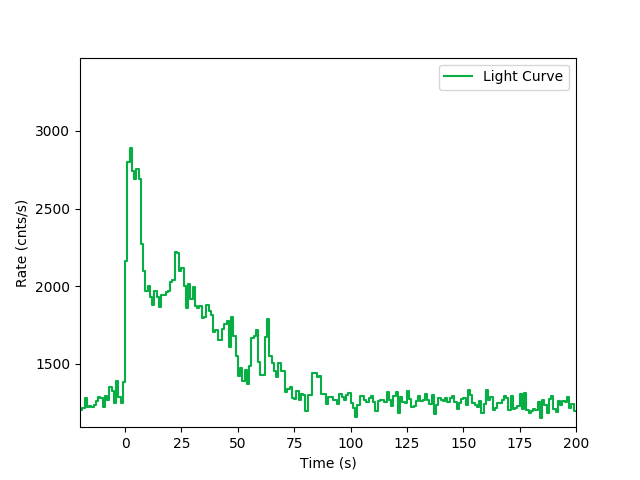

In [4]:
threeML_config['lightcurve']['lightcurve color'] = '#07AE44'

fig = gbm_tte.view_lightcurve(start=-20,stop=200)

Perhaps we want to fit the time interval from 0-10 seconds. We make a selection like this:

<IPython.core.display.Javascript object>


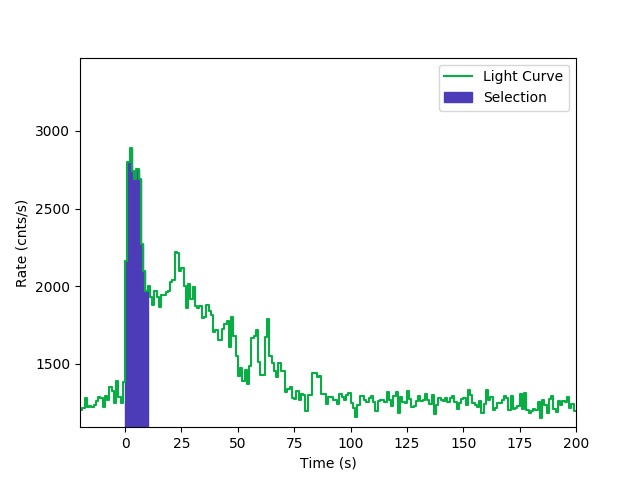

In [5]:
threeML_config['lightcurve']['selection color'] = '#4C3CB7'

gbm_tte.set_active_time_interval('0-10')
fig = gbm_tte.view_lightcurve(start=-20,stop=200);

For event list style data like time tagged events, the selection is *exact*. However, pre-binned data in the form of e.g. PHAII files will have the selection automatically adjusted to the underlying temporal bins.

Several discontinuous time selections can be made.

## Fitting a polynomial background

In order to get to a plugin, we need to model and create an estimated background in each channel ($B_i$) for our interval of interest. The process that we have implemented is to fit temporal off-source regions to polynomials ($P(t;\vec{\theta})$) in time. First, a polynomial is fit to the total count rate. From this fit we determine the best polynomial order via a likelihood ratio test, unless the user supplies a polynomial order in the constructor or directly via the polynomial_order attribute. Then, this order of polynomial is fit to every channel in the data.

From the polynomial fit, the polynomial is integrated in time over the active source interval to estimate the count rate in each channel. The estimated background and background errors then stored for each channel.

$$ B_i = \int_{T_1}^{T_2}P(t;\vec{\theta}) {\rm d}t $$


Auto-determined polynomial order: 0




Unbinned 0-order polynomial fit with the Nelder-Mead method




<IPython.core.display.Javascript object>


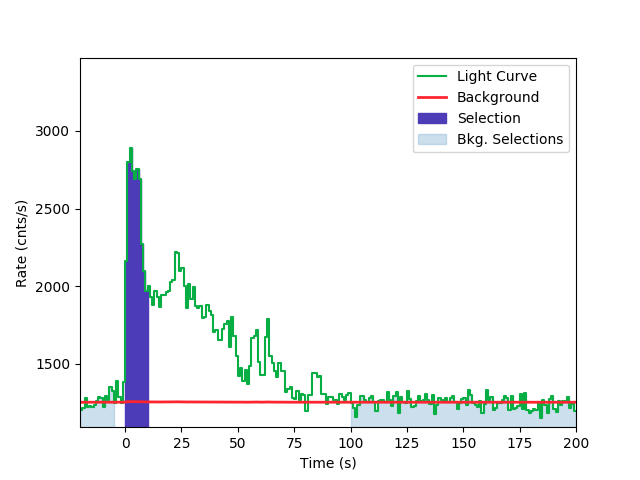

In [6]:
threeML_config['lightcurve']['background color'] = '#FC2530'

gbm_tte.set_background_interval('-24--5','100-200')
gbm_tte.view_lightcurve(start=-20,stop=200);

For event list data, binned or unbinned background fits are possible. For pre-binned data, only a binned fit is possible. 

In [7]:
gbm_tte.set_background_interval('-24--5','100-200',unbinned=False)

Auto-determined polynomial order: 4




Binned 4-order polynomial fit with the Powell method




## Saving the background fit

The background polynomial coefficients can be saved to disk for faster manipulation of time series data.


In [8]:
gbm_tte.save_background('background_store',overwrite=True)


Saved fitted background to background_store.h5.



In [9]:
gbm_tte_reloaded = TimeSeriesBuilder.from_gbm_tte('nai3_tte',
                                          tte_file=tte_file,
                                          rsp_file=gbm_rsp,
                                          restore_background='background_store.h5')

Successfully restored fit from background_store.h5


<IPython.core.display.Javascript object>


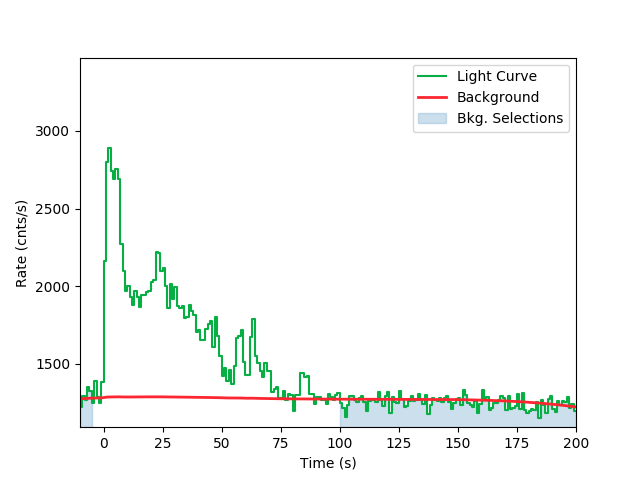

In [10]:
fig = gbm_tte_reloaded.view_lightcurve(-10,200)

## Creating a plugin

With our background selections made, we can now create a plugin instance. In the case of GBM data, this results in a **DispersionSpectrumLike**
plugin. Please refer to the Plugins documentation for more details.

In [11]:
gbm_plugin = gbm_tte.to_spectrumlike()

Auto-probed noise models:
- observation: poisson
- background: gaussian


In [12]:
gbm_plugin.display()

,0
n. channels,128
total rate,2506.5
total bkg. rate,1287.47
total bkg. rate error,20.6602
bkg. exposure,9.95012
bkg. is poisson,False
exposure,9.95012
is poisson,True
background,profiled
significance,47.7858


## Time-resolved binning and plugin creation

It is possible to temporally bin time series. There are up to four methods provided depending on the type of time series being used:

* Constant cadence (all time series)
* Custom (all time series)
* Significance (all time series)
* Bayesian Blocks (event lists)

### Constant Cadence

Constant cadence bins are defined by a start and a stop time along with a time delta.


In [13]:
gbm_tte.create_time_bins(start=0, stop=10, method='constant', dt=2.)

Created 5 bins via constant


In [14]:
gbm_tte.bins.display()

,Start,Stop,Duration,Midpoint
0,0.000412,2.000412,2.0,1.000412
1,2.000412,4.000412,2.0,3.000412
2,4.000412,6.000412,2.0,5.000412
3,6.000412,8.000412,2.0,7.000412
4,8.000412,10.000412,2.0,9.000412


### Custom

Custom time bins can be created by providing a contiguous list of start and stop times.



In [15]:
time_edges = np.array([.5,.63,20.,21.])

starts = time_edges[:-1]

stops = time_edges[1:]

gbm_tte.create_time_bins(start=starts, stop=stops, method='custom')

Created 3 bins via custom


In [16]:
gbm_tte.bins.display()

,Start,Stop,Duration,Midpoint
0,0.50,0.63,0.13,0.565
1,0.63,20.00,19.37,10.315
2,20.00,21.00,1.00,20.500


### Significance

Time bins can be created by specifying a significance of signal to background if a background fit has been performed.

In [17]:
gbm_tte.create_time_bins(start=0., stop=50., method='significance', sigma=25)

Created 12 bins via significance


In [18]:
gbm_tte.bins.display()

,Start,Stop,Duration,Midpoint
0,0.000412,1.334256,1.333844,0.667334
1,1.334256,1.810988,0.476732,1.572622
2,1.810988,2.411580,0.600592,2.111284
3,2.411580,2.849876,0.438296,2.630728
4,2.849876,3.454244,0.604368,3.152060
5,3.454244,4.090328,0.636084,3.772286
6,4.090328,4.724952,0.634624,4.407640
7,4.724952,5.544472,0.819520,5.134712
8,5.544472,6.033726,0.489254,5.789099
9,6.033726,6.734410,0.700684,6.384068


### Bayesian Blocks

The Bayesian Blocks algorithm (Scargle et al. 2013) can be used to bin event list by looking for significant changes in the rate. 


In [19]:
gbm_tte.create_time_bins(start=0., stop=50., method='bayesblocks', p0=.01, use_background=True)

Created 9 bins via bayesblocks


In [20]:
gbm_tte.bins.display()

,Start,Stop,Duration,Midpoint
0,0.000412,0.816854,0.816442,0.408633
1,0.816854,6.983690,6.166836,3.900272
2,6.983690,8.823971,1.840281,7.903831
3,8.823971,21.723166,12.899195,15.273569
4,21.723166,25.502056,3.778890,23.612611
5,25.502056,30.894882,5.392826,28.198469
6,30.894882,38.893854,7.998972,34.894368
7,38.893854,48.517036,9.623182,43.705445
8,48.517036,49.999594,1.482558,49.258315


### Working with bins

The light curve can be displayed by supplying the use_binner option to display the time binning


<IPython.core.display.Javascript object>


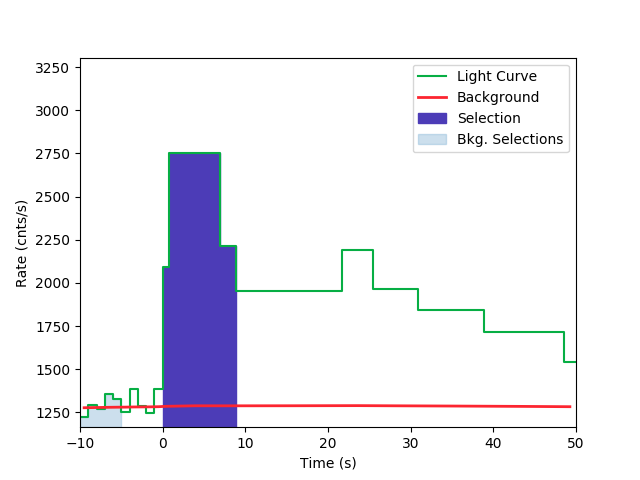

In [21]:
fig = gbm_tte.view_lightcurve(use_binner=True)

The bins can all be writted to a PHAII file for analysis via OGIPLike.

In [22]:
gbm_tte.write_pha_from_binner(file_name='out', overwrite=True,
                              force_rsp_write = False)  # if you need to write the RSP to a file. We try to choose the best option for you.

Similarly, we can create a list of plugins directly from the time series.

In [23]:
my_plugins = gbm_tte.to_spectrumlike(from_bins=True)